In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import ast
import scipy
import mdtraj as md
import MDAnalysis
from typing import Dict, Tuple
import os

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 150,                   # medium resolution

    # Axes
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

def find_xtc_filenames(path_to_dir, suffix=".xtc"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

# --- Utility functions ---
def RMSE(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.sqrt(np.mean((actual - predicted)**2))

# Function to calculate helical fraction
def helical_fraction(ss_line):
    helix_chars = {'H', 'G', 'I'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate per-residue helicity per frame
def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

# functions for analysis of RDCs
# function to parse calculated RDC data
def read_calc_RDCs(filename):
    residues = []
    data = []
    with open(filename,'r') as f:
        lines = f.readlines()
        for line in lines[1:]:
            residues.append(int(line.split(',')[0]))

        for line in lines[1:]:
            dat = np.array(line.split(',')[1:]).astype(float)
            data.append(dat)

    data = np.array(data).T * -1 # account for negative gyromagnetic ratio of 15N

    return residues, data

def scale_rdcs_to_minimize_q(calc, exp, weights, prior='True', scale_matching = 'True'):
    calc = np.array(calc)
    exp = np.array(exp)

    if prior=='True':
        mask_nan = ~np.isnan(weights) # to remove unphysical conformations from averagin
        calc = np.average(calc[mask_nan, :], axis=0)
    else:
        weights = np.nan_to_num(weights,nan=0)
        weights = weights / np.sum(weights)
        calc = np.average(calc, weights=weights, axis=0)

    # if scale_matching - extract datapoints satisfying this
    if scale_matching=='True':
        try:
            prod = calc*exp
            keepidxs = np.where(prod>0)[0]
            #print('keeping {} / {} datapoints for scaling...'.format(keepidxs.shape[0], calc.shape[0]))
            calcfilt = calc[keepidxs]
            expfilt = exp[keepidxs]
            # Compute unconstrained scaling factor
            s = np.sum(calcfilt * expfilt) / np.sum(calcfilt ** 2)
        except:
            print('Warning: no matching RDCs found for scaling, returning nothing...')
            return

    else:
        # Compute unconstrained scaling factor
        s = np.sum(calc * exp) / np.sum(calc ** 2)

    # Constrain s to be ≥ 0 (should be satisfied already if scale_matching)
    s = max(s, 0)

    scaled = s * calc
    q = np.sqrt(np.mean((scaled - exp)**2)) / np.sqrt(np.mean(exp**2))
    q_nonscaled = np.sqrt(np.mean((calc - exp)**2)) / np.sqrt(np.mean(exp**2))

    return scaled, s, q, q_nonscaled

data_path = '../Ensemble_reweighting/'

/home/thd711/.conda/envs/HDXproject/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:345: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/thd711/.conda/envs/HDXproject/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


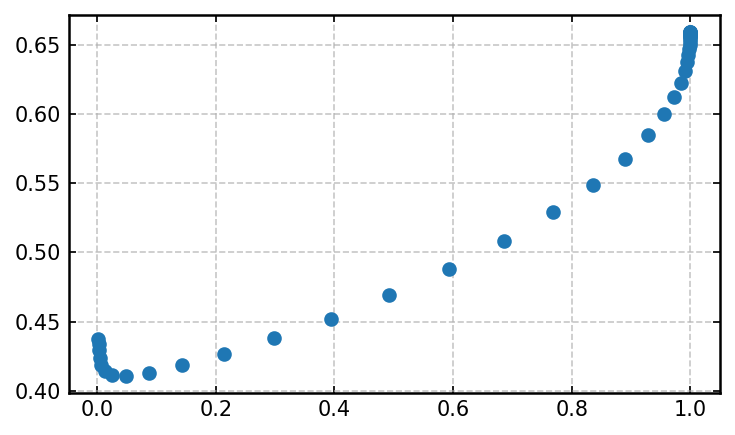

In [2]:
# analyse, cross-validation
rew_dir = 'opes_rew_cs_saxs/'

protein = 'ACTR_OPES_310K_ensemble'

traj_names = np.sort(find_xtc_filenames(data_path+f'./{protein}/'))

# load RDC data
for i in range(len(traj_names)):
    if i==0:
        residues, data = read_calc_RDCs(data_path+f'./{protein}/RDC/RDC_{traj_names[i]}.csv')
    else:
        residues, tmpdata = read_calc_RDCs(data_path+f'./{protein}/RDC/RDC_{traj_names[i]}.csv')
        data= np.concatenate((data, tmpdata), axis=0)

# experimental data
expres = np.loadtxt(data_path+f'./exp_data_ACTR/RDC_HN.dat').astype(int)[:,0]
exprdc = np.loadtxt(data_path+f'./exp_data_ACTR/RDC_HN.dat')[:,1]
# remove nan rows
exp_mask_nan = ~np.isnan(exprdc)
expres = expres[exp_mask_nan]
exprdc = exprdc[exp_mask_nan]

# number of total residues
prot_length=MDAnalysis.Universe(data_path+f'./{protein}/protein.pdb').select_atoms('name CA').indices.shape[0]
# remove first and last residue from experiment
if expres[0]==1:
    expres=expres[1:]
    exprdc=exprdc[1:]
elif expres[-1]==prot_length:
    expres=expres[:-1]
    exprdc=exprdc[:-1]

# sim indices for which there are experiments
idxs = []
for ele in expres:
    idx = list(residues).index(ele)
    idxs.append(idx)
idxs=np.array(idxs).astype(int)
sim_rdc_residues= np.array(residues)[idxs]
data = np.array(data)[:,idxs]

# load reweighting data
wopt_array = np.load(data_path+rew_dir+f"rew_wopt_array.npy")
neffs = np.loadtxt(data_path+rew_dir+f"rew_neffs.txt")
relESS = []
Qfactors = []
for W in wopt_array:
    scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, W, prior='False', scale_matching='True')
    Qfactors.append(q)
    relESS.append((np.sum(W)**2/np.sum(W**2))/W.shape[0])

# save data
np.savetxt(data_path+rew_dir+"RDC_Qfactors.txt", Qfactors)

# plot
plt.figure(figsize = (5, 3))



plt.plot(neffs, Qfactors, 'o')

plt.tight_layout()
plt.show()



/home/thd711/.conda/envs/HDXproject/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:345: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/thd711/.conda/envs/HDXproject/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


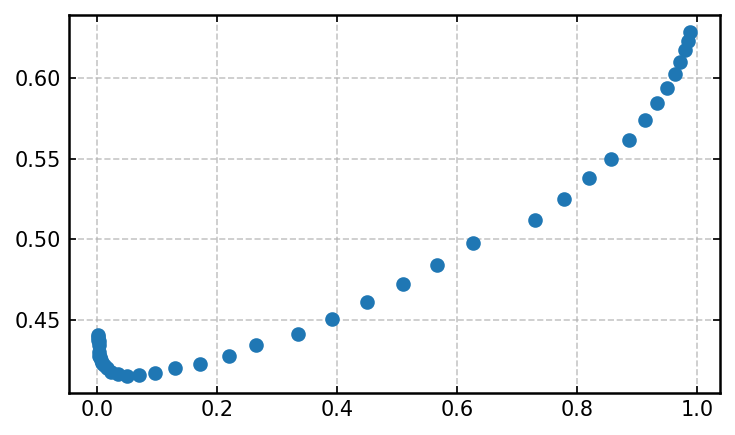

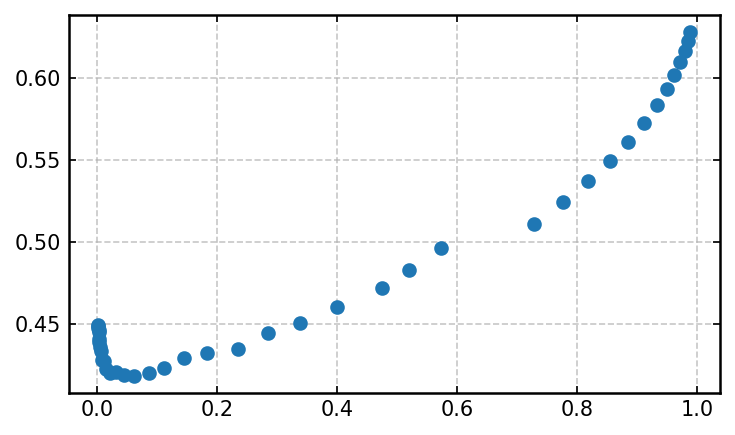

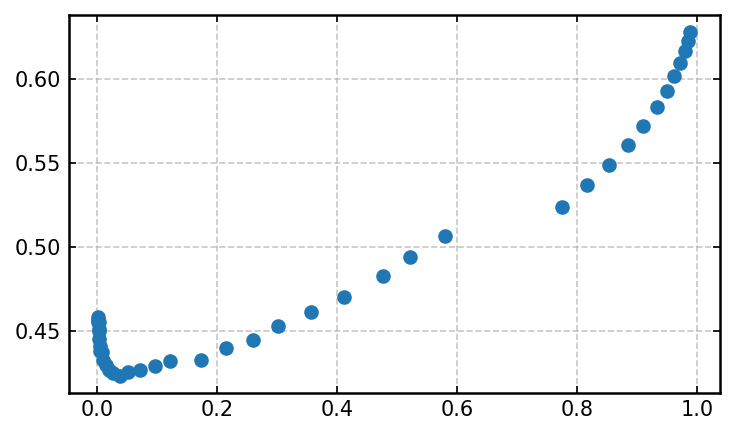

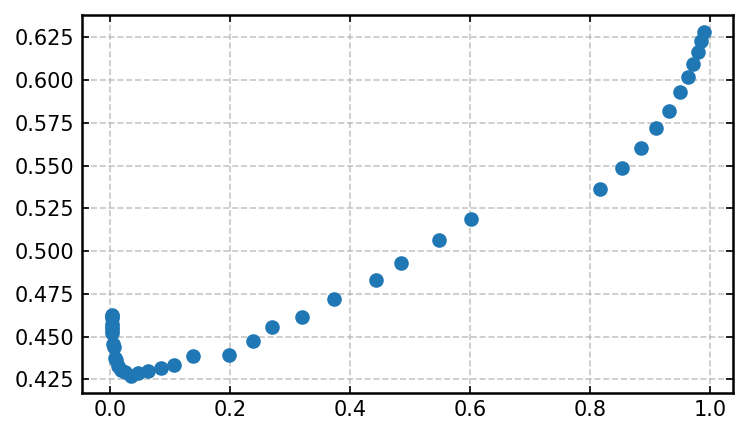

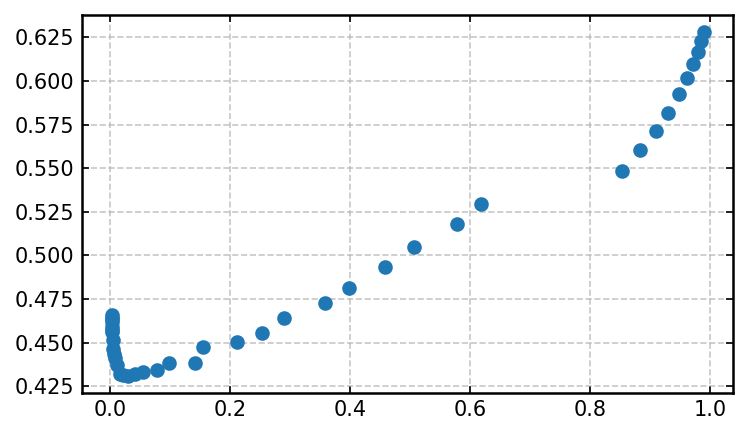

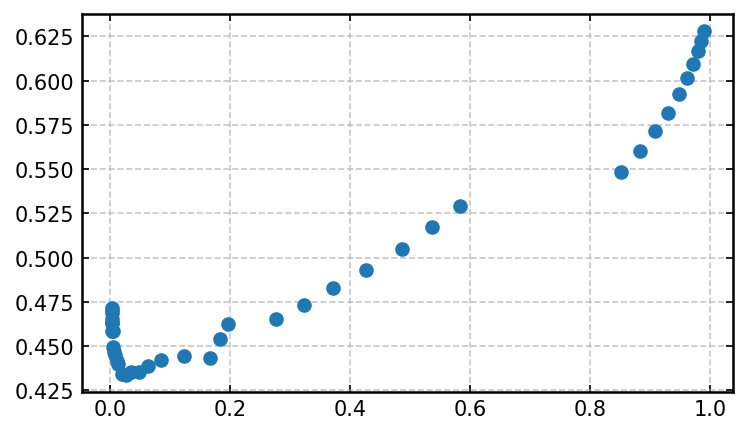

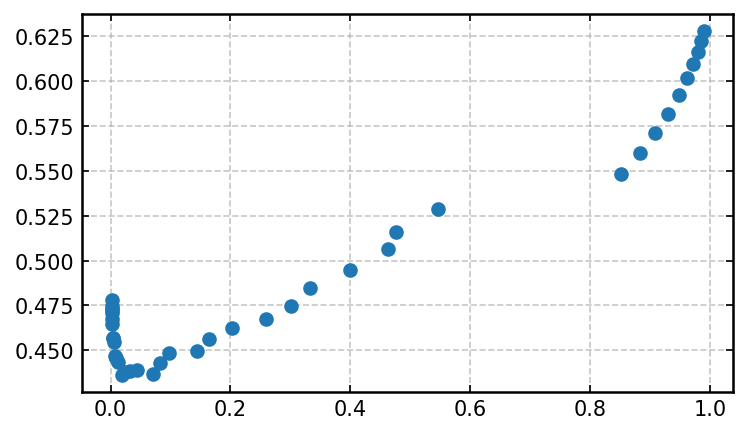

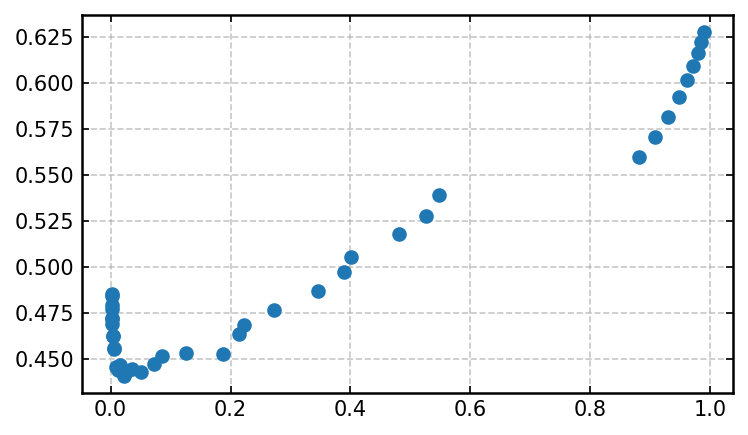

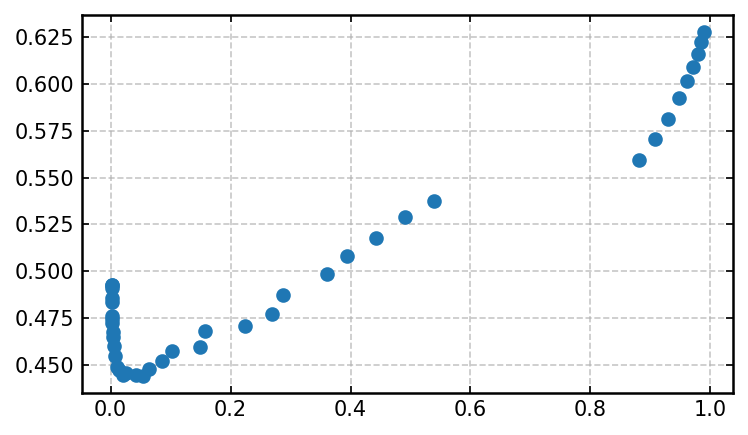

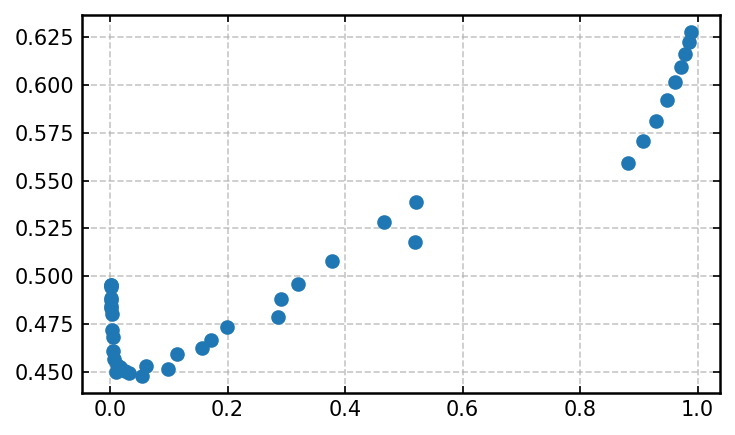

In [3]:
# analyse, cross-validation
tauc_values = np.arange(1.0, 11.0, 1.0)
rew_dir = 'opes_rew_cs_pre/'

frames = np.loadtxt(data_path+rew_dir+f"PREframes.txt").astype(int)

protein = 'ACTR_OPES_310K_ensemble'
# load alpharmsd
alpha = np.loadtxt(data_path+f"./{protein}/alpharmsd_opes_310K.txt")
include = np.where(alpha<100)[0]


traj_names = np.sort(find_xtc_filenames(f'./{protein}/'))

# load RDC data
for i in range(len(traj_names)):
    if i==0:
        residues, data = read_calc_RDCs(data_path+f'./{protein}/RDC/RDC_{traj_names[i]}.csv')
    else:
        residues, tmpdata = read_calc_RDCs(data_path+f'./{protein}/RDC/RDC_{traj_names[i]}.csv')
        data= np.concatenate((data, tmpdata), axis=0)

data = data[frames]
# experimental data
expres = np.loadtxt(data_path+f'./exp_data_ACTR/RDC_HN.dat').astype(int)[:,0]
exprdc = np.loadtxt(data_path+f'./exp_data_ACTR/RDC_HN.dat')[:,1]
# remove nan rows
exp_mask_nan = ~np.isnan(exprdc)
expres = expres[exp_mask_nan]
exprdc = exprdc[exp_mask_nan]

# number of total residues
prot_length=MDAnalysis.Universe(data_path+f'./{protein}/protein.pdb').select_atoms('name CA').indices.shape[0]
# remove first and last residue from experiment
if expres[0]==1:
    expres=expres[1:]
    exprdc=exprdc[1:]
elif expres[-1]==prot_length:
    expres=expres[:-1]
    exprdc=exprdc[:-1]

# sim indices for which there are experiments
idxs = []
for ele in expres:
    idx = list(residues).index(ele)
    idxs.append(idx)
idxs=np.array(idxs).astype(int)
sim_rdc_residues= np.array(residues)[idxs]
data = np.array(data)[:,idxs]

for tc in tauc_values:
    # load reweighting data
    wopt_array = np.load(data_path+rew_dir+f"rew_wopt_array{tc}ns.npy")
    neffs = np.loadtxt(data_path+rew_dir+f"rew_neffs{tc}ns.txt")
    relESS = []
    Qfactors = []
    for W in wopt_array:
        scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, W, prior='False', scale_matching='True')
        Qfactors.append(q)
        relESS.append((np.sum(W)**2/np.sum(W**2))/W.shape[0])

    # save data
    np.savetxt(data_path+rew_dir+f"RDC_Qfactors_{tc}ns.txt", Qfactors)

    # plot
    plt.figure(figsize = (5, 3))



    plt.plot(neffs, Qfactors, 'o')

    plt.tight_layout()
    plt.show()



18


/home/thd711/.conda/envs/HDXproject/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:345: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/thd711/.conda/envs/HDXproject/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


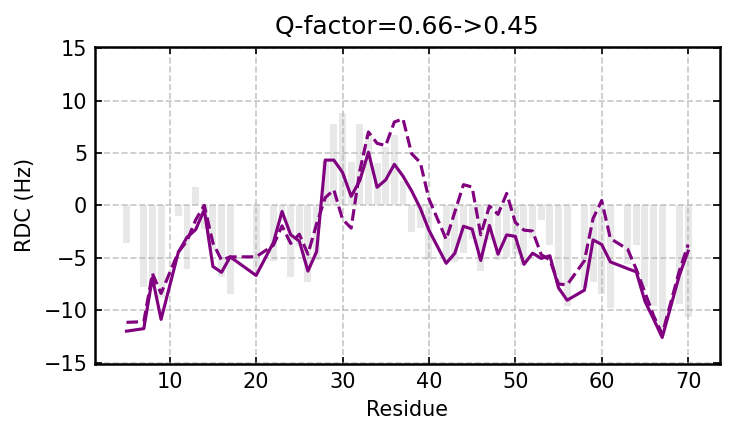

In [4]:
# plot prior vs posterior


protein = 'ACTR_OPES_310K_ensemble'

# reweighting directory
rew_dir = 'opes_rew_cs_pre/'
tc = 5.0 # tauc value used

# Load data
wopt_array = np.load(data_path+rew_dir+f'rew_wopt_array{tc}ns.npy')
neffs = np.loadtxt(data_path+rew_dir+f'rew_neffs{tc}ns.txt')
# Find the last index where neffs > 0.2
idx_opt = np.where(neffs > 0.2)[0][-1]
print(idx_opt)
# PRE frames
PREframes = np.loadtxt(data_path+rew_dir+"PREframes.txt").astype(int)
prior_weights = np.ones(wopt_array[0].shape[0])/wopt_array[0].shape
#prior_weights = np.loadtxt(protein+"/weights_310K.txt")[PREframes]

traj_names = np.sort(find_xtc_filenames(f'./{protein}/'))

# load RDC data
for i in range(len(traj_names)):
    if i==0:
        residues, data = read_calc_RDCs(data_path+f'./{protein}/RDC/RDC_{traj_names[i]}.csv')
    else:
        residues, tmpdata = read_calc_RDCs(data_path+f'./{protein}/RDC/RDC_{traj_names[i]}.csv')
        data= np.concatenate((data, tmpdata), axis=0)

# experimental data
expres = np.loadtxt(data_path+f'./exp_data_ACTR/RDC_HN.dat').astype(int)[:,0]
exprdc = np.loadtxt(data_path+f'./exp_data_ACTR/RDC_HN.dat')[:,1]
# remove nan rows
exp_mask_nan = ~np.isnan(exprdc)
expres = expres[exp_mask_nan]
exprdc = exprdc[exp_mask_nan]

# number of total residues
prot_length=MDAnalysis.Universe(data_path+f'./{protein}/protein.pdb').select_atoms('name CA').indices.shape[0]
# remove first and last residue from experiment
if expres[0]==1:
    expres=expres[1:]
    exprdc=exprdc[1:]
elif expres[-1]==prot_length:
    expres=expres[:-1]
    exprdc=exprdc[:-1]

# sim indices for which there are experiments
idxs = []
for ele in expres:
    idx = list(residues).index(ele)
    idxs.append(idx)
idxs=np.array(idxs).astype(int)
sim_rdc_residues= np.array(residues)[idxs]
data = np.array(data)[:,idxs]

scaled_prior, s, q_prior, q_nonscaled = scale_rdcs_to_minimize_q(data[PREframes], exprdc, prior_weights, prior='False', scale_matching='True')
scaled_post, s, q_post, q_nonscaled = scale_rdcs_to_minimize_q(data[PREframes], exprdc, wopt_array[idx_opt], prior='False', scale_matching='True')            

# plot
plt.figure(figsize = (5, 3))

plt.title(f"Q-factor={q_prior:.2f}->{q_post:.2f}")

# experimental values
axlim = np.max(np.abs(exprdc))
plt.bar(expres, exprdc, color = 'lightgrey', alpha=0.5, label='Exp.')
plt.ylim(-axlim*1.3,axlim*1.3)
plt.xlabel("Residue"); plt.ylabel(f"RDC (Hz)")

plt.plot(sim_rdc_residues, scaled_prior, color="purple", label="Prior", linewidth=1.5, linestyle='dashed')
plt.plot(sim_rdc_residues, scaled_post, color="purple", label="Posterior", linewidth=1.5)
plt.tight_layout()
plt.savefig(data_path+rew_dir+f"RDC_prior_post.pdf")

